In [1]:
#Python 2&3 compartibility
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# stable output across runs
np.random.seed(42)

# pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None

In [2]:
#to replicate class output I will keep random state 1 
rng = np.random.RandomState(1)
x = 10 * rng.rand(150)
print('x', x.shape, x.dtype)
y = 2 * x - 5 + rng.randn(150) # generate noise from a standard normal distribution
print('y', y.shape, y.dtype)

x (150,) float64
y (150,) float64


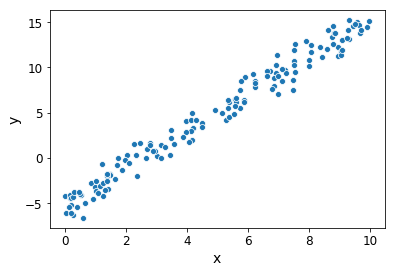

In [3]:
sns.scatterplot(x, y) 
plt.xlabel('x')
plt.ylabel('y');

-5.154927422232134 [2.0501849]
-5.154927422232134 [2.0501849]


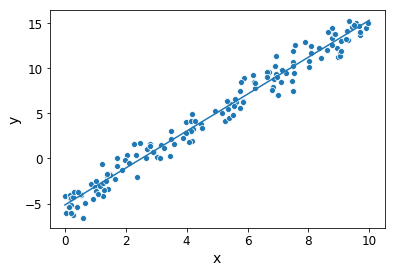

In [4]:
#using sckit learn linear regression to fit the data (closed form solution)

from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(x.reshape(-1,1),y) # or create a new axis np.newaxis

print(lr.intercept_, lr.coef_)

lr.fit(x[:,np.newaxis],y)

print(lr.intercept_, lr.coef_)

xfit = np.linspace(0,10,1000)
yfit = lr.predict(xfit[:,np.newaxis])

sns.scatterplot(x,y)
plt.plot(xfit,yfit)
plt.xlabel('x')
plt.ylabel('y');

(150, 2)
[-5.15492742  2.0501849 ]


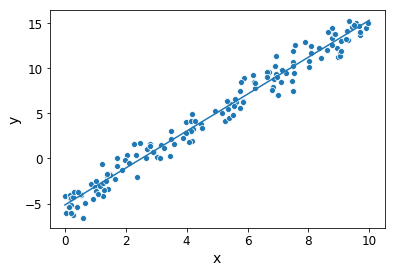

In [5]:
x_b = np.c_[np.ones((x.shape[0],1)), x[:,np.newaxis]] #initialize x with bias 1
print(x_b.shape)
x_b[:10]

#lets use the closed form equation to solve the regression first this is also usin sklearn LinearReg class
weights_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)
print(weights_best) #looks pretty good. exactly same as our scikit learn linear closed form model

#lets prdict and plot 
yfit = xfit.dot(weights_best[1]) + weights_best[0]

sns.scatterplot(x,y)
plt.plot(xfit,yfit)
plt.xlabel('x')
plt.ylabel('y'); #looks good 

In [6]:
#we can also use scipy.linalg.lstsq() to predict the model parameters
weights_best, _, _, _ = np.linalg.lstsq(x_b, y, rcond=1e-6)
print(weights_best)

np.linalg.pinv(x_b).dot(y) #same solution another way

[-5.15492742  2.0501849 ]


array([-5.15492742,  2.0501849 ])

[-4.97130082] [2.01716603]


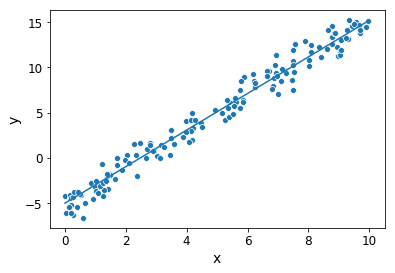

In [7]:
#using sckit learn gradient descent class
from sklearn.linear_model import SGDRegressor

lr_gd = SGDRegressor(penalty=None, max_iter=1000, tol=1e-3)
lr_gd.fit(x[:, np.newaxis],y)

print(lr_gd.intercept_, lr_gd.coef_)

yfit = lr_gd.predict(xfit[:,np.newaxis])

sns.scatterplot(x,y)
plt.plot(xfit,yfit)
plt.xlabel('x')
plt.ylabel('y');

[2.05003441] -5.153916861526987


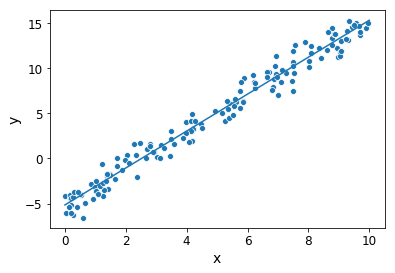

In [8]:
#using model taught in class gradient descent approach

class MyLRModel():
    def __init__(self, niter=1000, alpha=0.03):
        self.niter = niter
        self.alpha = alpha
    
    def fit(self, X, y):
        N, m = X.shape #N=rows, m= features, I prefer to name them in opposite order this is giving me a headache #Damnit
        self.w = np.random.rand(m) #initialize the weights (m defines how many attribute so that many features)
        self.b = 0  #initialize bias
        for i in range(self.niter): # we chose 50 iterations so loop will run 50 times
            y_ = np.dot(X, self.w) + self.b #predict y 
            z = np.average(y_ - y)
            loss = 0.5 * np.average((y_ - y) * (y_ - y))
            db = z #change bias 
            dw = np.dot((y_ - y).T, X) / N #compute gradient
            self.w = self.w - self.alpha * dw
            self.b = self.b - self.alpha * db
            #print(loss)
        self.coef_ = self.w
        self.intercept_ = self.b
        
    def predict(self, X):
        return np.dot(X, self.w) + self.b
    
lr_my_model1 = MyLRModel()
lr_my_model1.fit(x[:,np.newaxis],y)
print(lr_my_model1.coef_, lr_my_model1.intercept_)

yfit = lr_my_model1.predict(xfit[:, np.newaxis])

sns.scatterplot(x,y)
plt.plot(xfit,yfit)
plt.xlabel('x')
plt.ylabel('y'); 

In [9]:
#so lets fix this implementation and fix my headache 
#from now on m = no. of examples and n = no. of features

In [26]:
#Now let's do gradient descent implementation using a different approch 
#Batch gradient descent algorithm 
#try differnt learning rates see how the algorithm diverges or converges
eta = 0.03 #consider it as alpha - learning rate but remember I call it eta cause alpha is usded as regularization hyperparameter in many cases
n_epochs = 1000
m = x_b.shape[0]
weights = np.random.randn(x_b.shape[1],1) #initialize weights

for i in range(n_epochs):
    gradients = 2/m * x_b.T.dot(x_b.dot(weights) - y.reshape(-1,1))
    weights = weights - eta * gradients
    
print('slope', weights[1], 'intercept', weights[0]) #we arrived at the same answer with lot lesser codes
# what I exactly did is instead of computing bias and weights separately I added a bias term to data then initilized a weight for the bias term

slope [1.84814464] intercept [-5.18501519]


In [11]:
weights_path = []
def plot_gradient_descent(weights, eta, weights_path=None):
    m = len(x_b)
    plt.plot(x,y, 'b.')
    n_iter = 1000
    for i in range(n_iter):
        if i < 10: 
            y_pred = xfit_b.dot(weights)
            style = 'b-' if i >0 else 'r--'
            plt.plot(xfit,y_pred,style)
        gradients = 2/m * x_b.T.dot(x_b.dot(weights)-y)
        weights = weights - eta*gradients
        if weights_path is not None:
            weights_path.append(weights)
    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    

In [45]:
weights_path_bgd = []
x_new = np.linspace(0,10,2)
x_new_b = np.c_[np.ones((x_new.shape[0],1)), x_new[:,np.newaxis]]

def plot_gradient_descent(weights, eta, weights_path=None):
    m = len(x_b)
    plt.plot(x, y, "b.")
    n_iterations = 300
    for iteration in range(n_iterations):
        if iteration <10 or iteration>295:
            y_predict = x_new_b.dot(weights)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(x_new, y_predict, style)
        gradients = 2/m * x_b.T.dot(x_b.dot(weights) - y.reshape(-1,1))
        weights = weights - eta * gradients
        if weights_path is not None:
            weights_path.append(weights)
    plt.xlabel("x", fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.title('eta = {}'.format(eta))

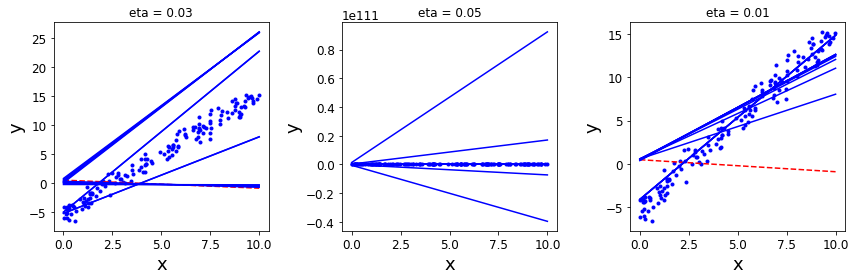

In [46]:
np.random.seed(42)
weights = np.random.randn(2,1)

plt.figure(figsize=(12,4))
plt.subplot(131)
plot_gradient_descent(weights,0.03)
plt.subplot(132)
plot_gradient_descent(weights,0.05)
plt.subplot(133)
plot_gradient_descent(weights,0.01, weights_path=weights_path_bgd) #with a higher learning rate algorithm is converging much faster in much fewer iterations
# 0.03 took 1000 iterations 0.01 converged within 300 
plt.tight_layout()

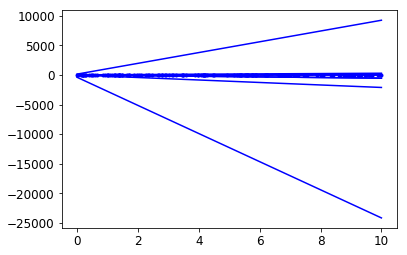

In [109]:
### Stochastic Gradient Descent #Simulated Annealing 
weights_path_sgd = []
m = x_b.shape[0]
np.random.seed(42)

n_epochs = 11
t0, t1 = 5, 100 #learning shcedule hyperparameters

def annealing(t):
    return t0/(t+t1)

eta=0.01
weights = np.random.randn(2,1) 

for epoch in range(n_epochs):
    for i in range(m):
        if epoch ==0 and i<10:
            y_predict = x_new_b.dot(weights)
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(x_new, y_predict, style)
        rand_instance = np.random.randint(m) #choose a random training instance
        xi = x_b[rand_instance:rand_instance+1]
        yi = y[rand_instance:rand_instance+1]
        gradients = 2 * xi.T.dot(xi.dot(weights)-yi)
        eta = annealing(eta*m+1)
        weights = weights - eta*gradients
        weights_path_sgd.append(weights)
        

plt.plot(x,y,'b.')


In [1]:
#Add Ridge Lasso - Models with Contours